In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

np.set_printoptions(precision=3, suppress=True)
print(tf.__version__)

2.4.1


In [2]:
# Загружаем датасет по ссылке, переименовывая название фичей.
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                      na_values='?', comment='\t',
                      sep=' ', skipinitialspace=True)

In [3]:
# Скопируем датасет, чтоб не запороть оригинал.
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
# Посмотрим на информацию о датасете.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [5]:
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
Cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
Displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
Weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
Acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
Model Year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
Origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [6]:
# dataset[dataset['Horsepower'].isna()]

In [7]:
# Удалим строки с пропущенными значениями.
dataset = dataset.dropna()

In [8]:
# Колонку 'Origin', так как она является категориальным значением, переведем в соответствующие страны происхождения.
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japane'})

In [9]:
# Создадим, на основе колонки 'Origin', One_hot вектора.
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japane,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [10]:
# Пазделим датасет на тренировочную и тестовую выборки.
train_dataset = dataset.sample(frac=0.8, random_state=113)
test_dataset = dataset.drop(train_dataset.index)

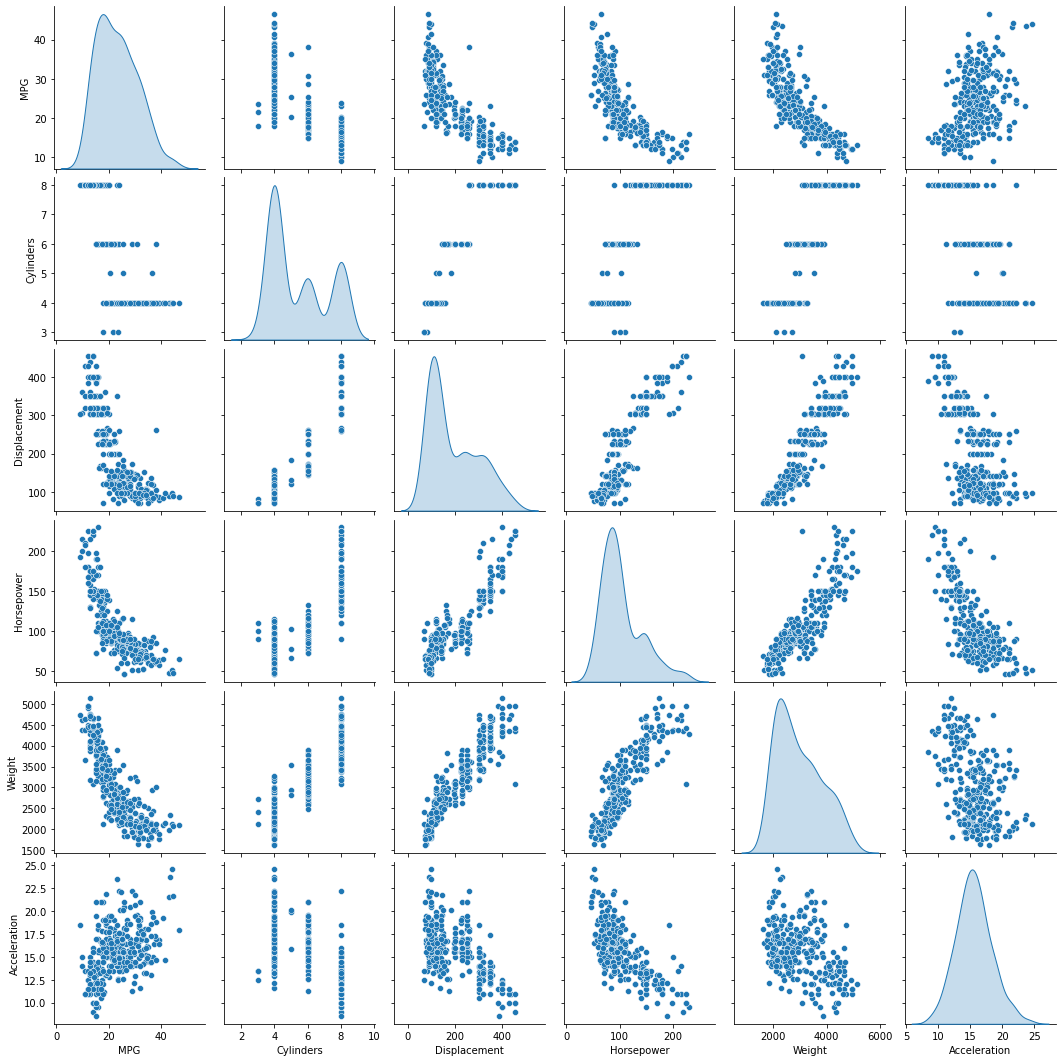

In [11]:
# Отобразим совместное распределение параметров.
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']], diag_kind='kde')

In [12]:
# Сделаем копию датосетов, для избегания ошибок при изменении.
train_feature = train_dataset.copy()
test_feature = test_dataset.copy()
# Отделим лейблы в Series, попутно удалив его из датасетов.
train_label = train_feature.pop('MPG')
test_label = test_feature.pop('MPG')

In [13]:
# Проверим данные на разброс, чтоб определить необходимость нормализации.
train_feature.describe().transpose()[['mean', 'std']]

,mean,std
Cylinders,5.452229,1.706765
Displacement,194.380573,105.294335
Horsepower,104.124204,39.167297
Weight,2974.633758,852.864467
Acceleration,15.585032,2.778109
Model Year,75.796178,3.656565
Europe,0.184713,0.388684
Japane,0.187898,0.391254
USA,0.627389,0.484272


In [14]:
# Для нормализации данных создадим специальный слой.
normalizer = preprocessing.Normalization()

In [15]:
# Адаптируем нормализатор к данных на тренировочной выборке. Для адаптации необходимо представить данные в массиве.
normalizer.adapt(np.array(train_feature))

In [16]:
normalizer.mean.numpy()

array([   5.452,  194.381,  104.124, 2974.634,   15.585,   75.796,
          0.185,    0.188,    0.627], dtype=float32)

In [17]:
# Постороим линейную регрессию на основе 1 фичи - Horsepower.
horsepower = np.array(train_feature['Horsepower'])

horsepower_normalizer = preprocessing.Normalization(input_shape=[1,])
horsepower_normalizer.adapt(horsepower)

In [18]:
# Построим модель.
horsepower_model = keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
], 
    name='Horsepower')

horsepower_model.summary()

Model: "Horsepower"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [19]:
# Скомпилируем модель.
horsepower_model.compile(loss='mean_absolute_error',
                        optimizer=tf.optimizers.Adam(learning_rate=0.1))

In [22]:
%%time
# Натренируем модель.
history = horsepower_model.fit(train_feature['Horsepower'], train_label,
                              verbose=0,
                              epochs=100,
                              validation_split=0.2)

Wall time: 7.65 s


In [23]:
# Для построения граффика, выделим необходимые элементы.
hist = pd.DataFrame(history.history)
hist_epochs = history.epoch
hist.head()

,loss,val_loss
0,22.973171,22.339771
1,22.162199,21.538225
2,21.361723,20.737572
3,20.567114,19.940592
4,19.759825,19.140558


In [24]:
def plot_loss(history):
    '''
    Функция для отрисовки граффика потерь.
    '''
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

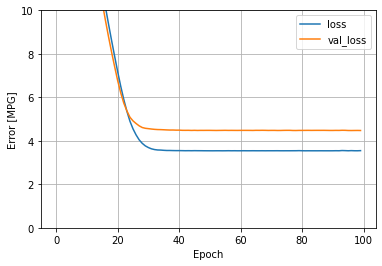

In [25]:
plot_loss(history)

In [26]:
# Создадим модель с нелинейными преобразованиями.
def build_and_compile_model():
    model = keras.Sequential([
        normalizer,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [27]:
dnn_model = build_and_compile_model()

In [28]:
%%time
history = dnn_model.fit(train_feature, train_label,
             epochs=100,
             validation_split=0.2,
             verbose=0)

Wall time: 6.72 s


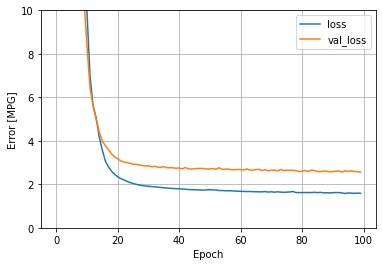

In [29]:
plot_loss(history)

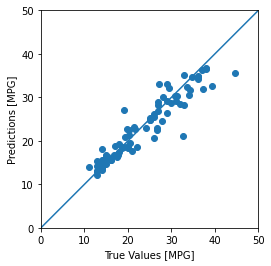

In [32]:
# Предсказываем показатели на тестовой выборке и отрисуем полученные значения.
test_predictions = dnn_model.predict(test_feature).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

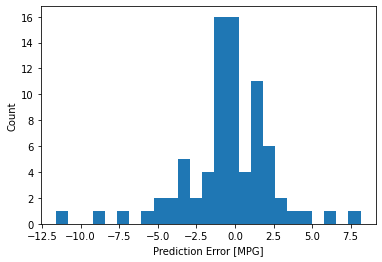

In [33]:
# Посмотрим распределение ошибки.
error = test_predictions - test_label
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')